In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/xingchenw/bo-on-graph


In [3]:
# test the GP cross validation
from problems import get_synthetic_problem
import torch
from search.trust_region import (
    restart,
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from search.utils import eigendecompose_laplacian


/opt/conda/envs/adapter/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [190]:
# n = 100
# base_problem = get_synthetic_problem(
#     "diffusion", 
#     n=n, 
#     seed=0, 
#     problem_kwargs={
#         "log": False, 
#         "random_graph_type": "ws", 
#         "m": 2,
#         "p": 0.1,
#         "k": 4,
#         "fraction_infected": 2./n,
#         "beta": 0.2,
#         "gamma": 0.,
#         })
n = 100
base_problem = get_synthetic_problem(
    "centrality", 
    n=n, 
    seed=2,
    problem_kwargs={
        "log": True, 
        "random_graph_type": "ba", #ba, ws, sbm
        "m": 3,
        # "p": 0.5,
        # "p": [
        #     [0.25, 0.02, 0.01], 
        #     [0.02, 0.35, 0.07], 
        #     [0.01, 0.07, 0.40]
        #     ],
        "sizes":  [75, 75, 300],
        "k": 4,
        "beta": 0.2,
        "gamma": 0.,
        "feature_name": "eigenvector_centrality"
        }
    )

n =400
base_problem = get_synthetic_problem(
    "test_function", 
    n=n, 
    seed=2,
    problem_kwargs={
        "log": False, 
        "random_graph_type": "grid",
        "m": 1,
        }
    )

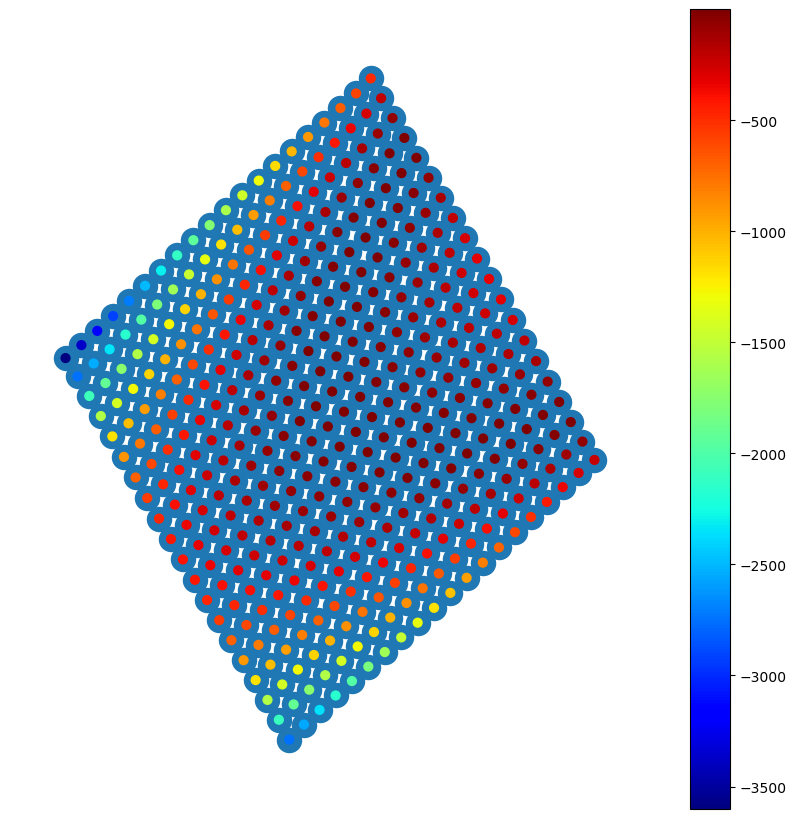

In [191]:
import networkx as nx
pos = nx.kamada_kawai_layout(base_problem.context_graph)
g = base_problem.context_graph
nodes = base_problem.context_graph.nodes()

all_X = torch.arange(len(base_problem.context_graph)).to(torch.float)
all_Y = base_problem(all_X.reshape(-1, 1))
# all_Y = eigenvecs[:, 0]
colors = all_Y
plt.figure(figsize=[8, 8])
nx.draw(base_problem.context_graph, pos, )
ec = nx.draw_networkx_edges(g, pos, alpha=0.2, )
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=40, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

In [200]:
# X = candidates.reshape(-1, 1).to(dtype=torch.float)
from botorch.utils.transforms import standardize
n_init = len(all_X)
X = all_X.reshape(-1, 1)


# Y = base_problem(X.reshape(-1, 1))
Y = all_Y.reshape(-1, 1).to(dtype=torch.float)
Y = standardize(Y)

best_loc = Y.argmax().item()
X_best = X[best_loc]

n_train = int(n_init * 0.25)
ntrain_indices = np.random.choice(n_init, n_train, replace=False)
ntest_indices = np.array([i for i in range(n_init) if i not in ntrain_indices])
X_train, Y_train = X[ntrain_indices, ...], Y[ntrain_indices]
X_test, Y_test = X[ntest_indices, ...], Y[ntest_indices, ...]

In [205]:
model, mll, cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="polynomial_new",
                covar_kwargs = {
                    "order": 20,
                     },
                fit_model=True,
                ard=True,
                use_fixed_noise=False,
                optim_kwargs = {
                    "train_iters": 300,
                    "lr": 0.1,
                    "print_interval": 1,
                    "mu_0": 1e-2
                },
                use_saas_map=False
                )


/opt/conda/envs/adapter/lib/python3.8/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


Iter 1/300: Loss=1.9729912281036377. Penalty=-9.045689582824707beta=Parameter containing:
tensor([0.0051, 0.0928, 0.1104, 0.0659, 0.1736, 0.0205, 0.0700, 0.0231, 0.0916,
        0.1034, 0.2362, 0.1859, 0.1260, 0.0476, 0.2300, 0.2046, 0.0395, 0.0981,
        0.0108, 0.1112], requires_grad=True)
Iter 2/300: Loss=1.586234450340271. Penalty=-4.348909378051758beta=Parameter containing:
tensor([ 0.1051,  0.1928,  0.2104,  0.1659,  0.2736,  0.1205,  0.1700,  0.1231,
         0.1916,  0.2034,  0.1362,  0.0859,  0.0260, -0.0524,  0.1300,  0.1046,
        -0.0605, -0.0019, -0.0892,  0.0112], requires_grad=True)
Iter 3/300: Loss=1.684146523475647. Penalty=-2.5962352752685547beta=Parameter containing:
tensor([ 0.1837,  0.2761,  0.2956,  0.2525,  0.3594,  0.2096,  0.2583,  0.2137,
         0.2746,  0.2678,  0.0938,  0.0654,  0.0476,  0.0156,  0.0528,  0.0321,
        -0.0093, -0.0138, -0.0271, -0.0225], requires_grad=True)
Iter 4/300: Loss=1.8395277261734009. Penalty=-1.536070704460144beta=Paramete

SignificanceResult(statistic=0.9999909990053898, pvalue=2.6051430468718626e-234)


/opt/conda/envs/adapter/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:959: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x = np.asarray(x)
/opt/conda/envs/adapter/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(x)
/opt/conda/envs/adapter/lib/python3.8/site-packages/matplotlib/colle

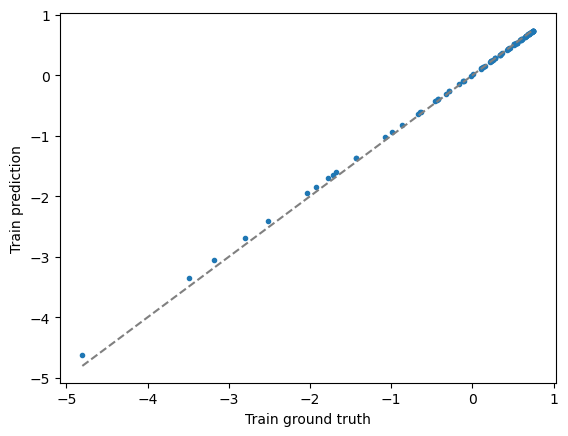

/tmp/ipykernel_60683/2908528801.py:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(
/tmp/ipykernel_60683/2908528801.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(l)


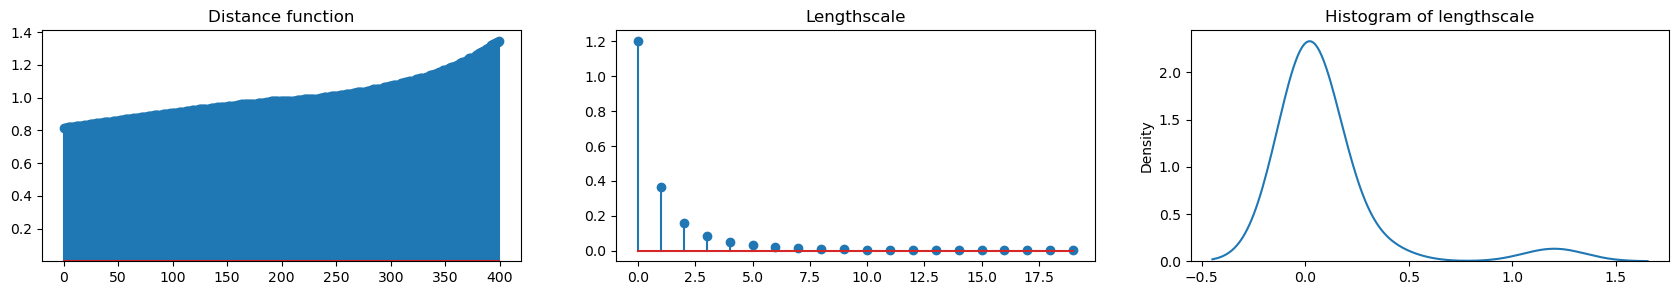

/tmp/ipykernel_60683/2908528801.py:46: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(torch.abs(eigenvecs.T @ all_Y))
/opt/conda/envs/adapter/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_60683/2908528801.py:49: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning a

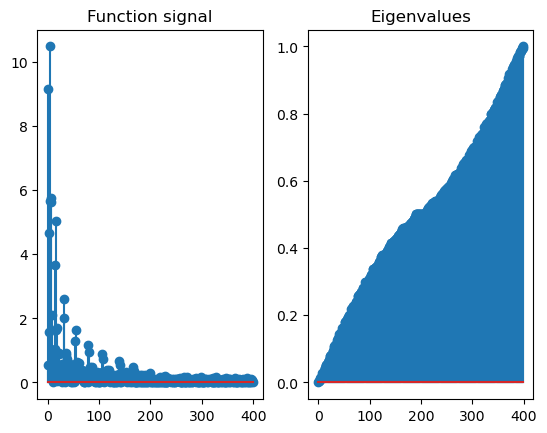

In [206]:
with torch.no_grad():
    # predict on train input
    Y_train_pred = model.posterior(X_train)
    Y_train_pred_mean, Y_train_pred_std = Y_train_pred.mean.flatten(), torch.sqrt(Y_train_pred.variance).flatten()
    plt.plot(Y_train, Y_train_pred_mean, ".")
    plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], color="gray", linestyle='--')
    plt.errorbar(Y_train, Y_train_pred_mean, yerr=Y_train_pred_std, linestyle="None", color="C0", alpha=0.3)
    plt.xlabel("Train ground truth")
    plt.ylabel("Train prediction")
    print(spearmanr(Y_train_pred_mean, Y_train))
plt.show()


if hasattr(model.covar_module.base_kernel, "lengthscale") and model.covar_module.base_kernel.lengthscale is not None:
    plt.figure(figsize=[21, 3])
    plt.subplot(131)
    plt.title("Distance function")
    with torch.no_grad():
        beta = model.covar_module.base_kernel._dists
        plt.stem(
            beta
        )
        # plt.yscale("log")
        plt.ylim([1e-3, None])

    l = model.covar_module.base_kernel.beta.flatten()
    with torch.no_grad():
        plt.subplot(132)
        plt.title("Lengthscale")
        # plt.yscale("log")
        plt.stem(l)
        plt.subplot(133)
        plt.title("Histogram of lengthscale")
        sns.kdeplot(l)
        # sample for priors
        if hasattr(model.covar_module.base_kernel, "lengthscale_prior") and \
                    model.covar_module.base_kernel.lengthscale_prior is not None:
            prior = model.covar_module.base_kernel.lengthscale_prior 
            prior_samples = torch.stack([prior.sample() for _ in range(100)])
            sns.kdeplot(prior_samples, alpha=0.5)
    
    plt.show()
eigenvals, eigenvecs = eigendecompose_laplacian(g )
plt.subplot(121)
plt.title("Function signal")
plt.stem(torch.abs(eigenvecs.T @ all_Y))
plt.subplot(122)
plt.title("Eigenvalues")
plt.stem(eigenvals.flatten())
plt.show()


SignificanceResult(statistic=-0.43157515784005107, pvalue=4.8516952003313725e-15)


/opt/conda/envs/adapter/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:959: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x = np.asarray(x)
/opt/conda/envs/adapter/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(x)
/opt/conda/envs/adapter/lib/python3.8/site-packages/matplotlib/colle

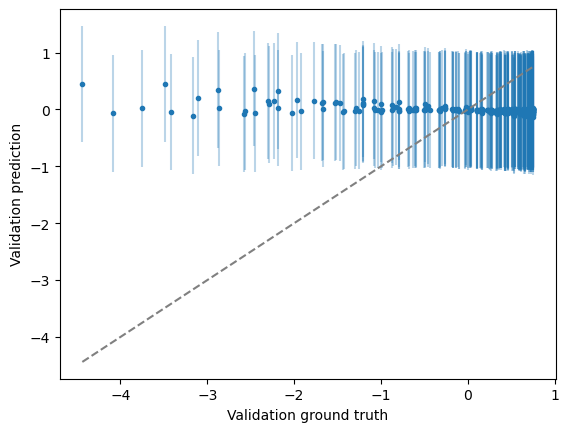

In [207]:
model.eval()
with torch.no_grad():
    # predict on train input
    Y_test_pred = model.posterior(X_test)
    lower, upper = Y_test_pred.mvn.confidence_region()

    Y_test_pred_mean, Y_test_pred_std = Y_test_pred.mean.flatten(), torch.sqrt(Y_test_pred.variance).flatten()
    plt.plot(Y_test, Y_test_pred_mean, ".")
    plt.errorbar(Y_test, Y_test_pred_mean, yerr=Y_test_pred_std, linestyle="None", color="C0", alpha=0.3)
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color="gray", linestyle='--')
    print(spearmanr(Y_test_pred_mean, Y_test))
    plt.xlabel("Validation ground truth")
    plt.ylabel("Validation prediction")

/opt/conda/envs/adapter/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


Text(0.5, 1.0, 'GP prediction')

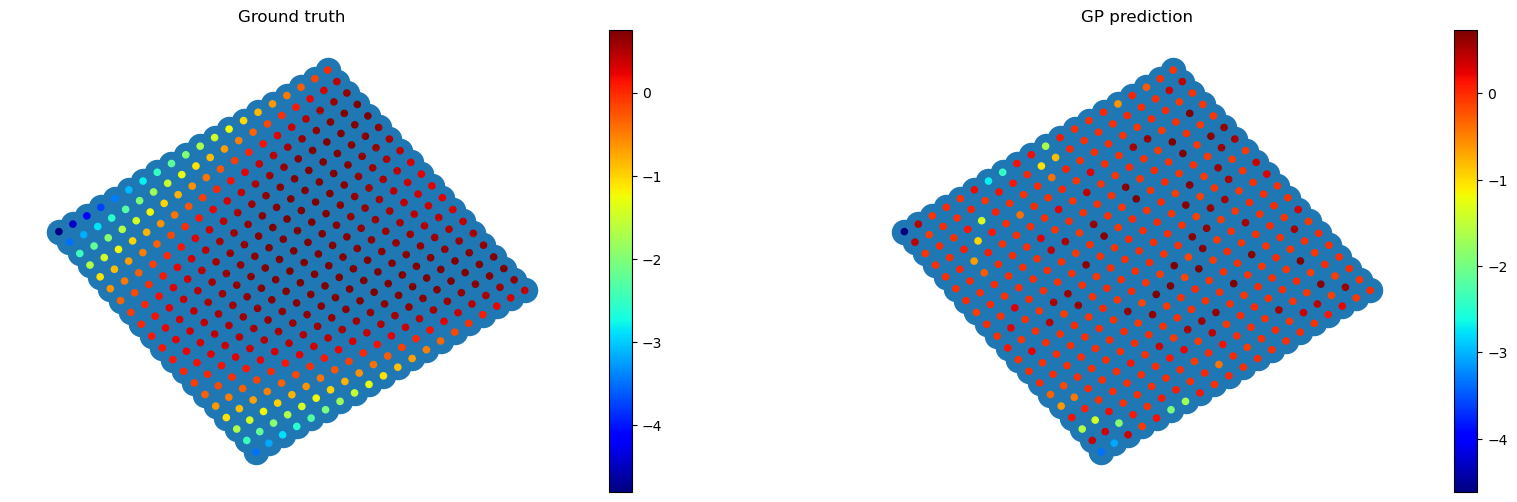

In [204]:
import networkx as nx
pos = nx.kamada_kawai_layout(base_problem.context_graph)
g = base_problem.context_graph
nodes = base_problem.context_graph.nodes()


all_X = torch.arange(len(base_problem.context_graph)).to(torch.float)
all_Y = standardize(base_problem(all_X.reshape(-1, 1)))

train_X = X_train.long().flatten().tolist()
test_X = X_test.long().flatten().tolist()
train_Y = [all_Y[i] for i in train_X]
test_Y = [all_Y[i] for i in test_X]
train_pos = {k: pos[k] for k in train_X}
test_pos = {k: pos[k] for k in test_X}

plt.figure(figsize=[20, 6])
plt.subplot(121)
nx.draw(base_problem.context_graph, pos, )
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
c = nx.draw_networkx_nodes(g, pos, node_color=all_Y, node_size=20, cmap=plt.cm.jet, linewidths=None, edgecolors=None)

# nc = nx.draw_networkx_nodes(g, train_pos, nodelist=train_X, node_color="gray", node_size=50, cmap=plt.cm.jet, linewidths=0)
# nc = nx.draw_networkx_nodes(g, test_pos, nodelist=test_X, node_color=test_Y, node_size=25, linewidths=0)

plt.colorbar(c)
plt.axis('off')
plt.title("Ground truth")

plt.subplot(122)
with torch.no_grad():
    posterior =  model.posterior(all_X.reshape(-1, 1))
    all_Y_pred =posterior.mean.flatten()
    all_Y_var =torch.sqrt(posterior.variance.flatten())

train_Y_pred = [all_Y_pred[i] for i in train_X]
test_Y_pred = [all_Y_pred[i] for i in test_X]

colors = all_Y_pred.clip(all_Y.min(), all_Y.max())

nx.draw(base_problem.context_graph, pos, )
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, node_color=colors, node_size=20, cmap=plt.cm.jet, linewidths=None)

# nc = nx.draw_networkx_nodes(g, train_pos, nodelist=train_X, node_color="gray", node_size=50, cmap=plt.cm.jet, linewidths=0)
# nc = nx.draw_networkx_nodes(g, test_pos, nodelist=test_X, node_color=test_Y_pred, node_size=25, linewidths=0)
plt.colorbar(nc)
plt.axis('off')
plt.title("GP prediction")


# plt.subplot(133)
# diff = torch.abs((all_Y_pred.flatten() - all_Y.flatten()) / all_Y.flatten())
# # diff.clip_(0, 0.2)

# nx.draw(base_problem.context_graph, pos, )
# ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
# nc = nx.draw_networkx_nodes(g, pos, node_color=diff, node_size=20, cmap=plt.cm.jet,)
# plt.colorbar(nc)
# plt.axis('off')
# plt.title("GP posterior std")

# plt.show()


<AxesSubplot:ylabel='Count'>

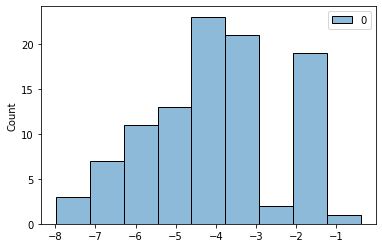

In [760]:
sns.histplot(all_Y)

<AxesSubplot:ylabel='Count'>

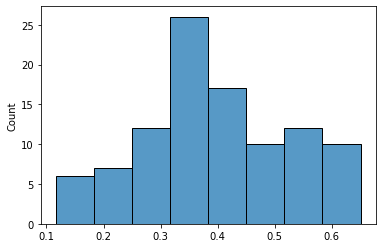

In [581]:
sns.histplot(all_Y_pred)

In [582]:
def eigendecompose_laplacian(
        context_graph: nx.Graph,
        dtype: torch.dtype = torch.float,
        normalized_laplacian: bool = True
):
    """
    Perform eigen-decomposition of ``context_graph``.
        We either take:
            a) a networkx graph.
    Note that the input graphs have to be directed to get a symmetric Laplacian and purely
        real eigenvalues
    Returns a tuple of torch.Tensor of shape ``N`` -> eigenvalues and ``N x N`` eigenvectors
    """
    if normalized_laplacian:
        L = nx.normalized_laplacian_matrix(context_graph).todense()
    else:
        L = nx.laplacian_matrix(context_graph).todense()
    L = torch.from_numpy(L).to(dtype)
    eigenvals, eigenvecs = torch.linalg.eigh(L, )
    return eigenvals, eigenvecs

<StemContainer object of 3 artists>

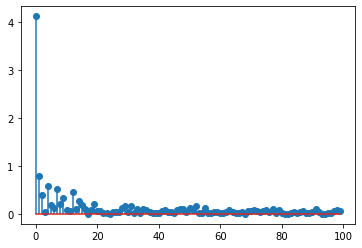

In [598]:
# plt.figure(figsize=[10, 1])
eigenvals, eigenvecs = eigendecompose_laplacian(g)
plt.stem(torch.abs(eigenvecs.T @ all_Y))


In [ ]:
# plt.figure(figsize=[10, 1])
plt.stem(torch.abs(eigenvecs.T @ all_Y))


<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


(0.0, 7.0)

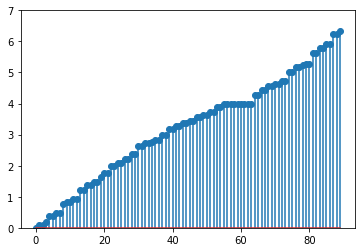

In [367]:
# plt.figure(figsize=[10, 1])
plt.stem(nx.laplacian_spectrum(g)[:-10], use_line_collection=True)
plt.ylim([0, 7])